**Predicting which Round of a Tennis Tournament in which a Match is Played**

**Introduction:** <p> Our goal for this project is to be able to predict which round of a tournament a tennis match occured, from top 128 to finals, based on relevant match data.</p> <p> The first round of a tournament begins with 128 players and after each match the number of players remaining is halved. This continues until quarterfinals(QF), then to semi-finals(SF), and ending with the grand finals(F).</p> <p>This includes data from both the winners and losers and the length of a match. This data was gathered from the 2021 matches played by athletes part of the Association of Tennis Professionals (ATP).</p>



In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(dplyr)
library(rvest)
library(tidymodels)
library(GGally)
library(ISLR)

options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attach

**Step 1:** <p> Read in the data, and select the potential columns of data that will be used. Since we want to investigate matches that are five sets long, filter for '5' in the 'best_of' column. Finally, split the data into training and testing sets, so that the accuracy of our model can be predicted later. 

In [2]:
tennis_data <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2021.csv") %>%
select(winner_name, loser_name, round, best_of, minutes, w_ace, w_svpt, winner_rank, w_bpSaved, l_ace, l_svpt, l_bpSaved, loser_rank) %>%
filter(best_of == 5)
tennis_data

tennis_split <- initial_split(tennis_data, prop = .75, strata = round)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)

Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



winner_name,loser_name,round,best_of,minutes,w_ace,w_svpt,winner_rank,w_bpSaved,l_ace,l_svpt,l_bpSaved,loser_rank
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Novak Djokovic,Jeremy Chardy,R128,5,91,9,57,1,0,3,86,7,61
Frances Tiafoe,Stefano Travaglia,R128,5,111,6,87,64,4,8,83,4,60
Reilly Opelka,Yen Hsun Lu,R128,5,115,18,84,38,1,3,92,5,1009
Taylor Fritz,Albert Ramos,R128,5,203,11,143,31,11,6,142,6,46
Stan Wawrinka,Pedro Sousa,R128,5,96,7,74,18,0,2,91,9,107
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Felix Auger Aliassime,Carlos Alcaraz,QF,5,68,8,43,15,3,1,47,5,55
Daniil Medvedev,Botic Van De Zandschulp,QF,5,143,13,99,2,3,4,114,5,117
Novak Djokovic,Alexander Zverev,SF,5,214,12,150,1,9,16,124,3,4


**Step 2:** <p>The data is currently separated into winner and loser stats. For it to be more useful, we need to combine those stats to make them into totals or averages, depending on which makes more sense for the type of variable. Before we do so, we get rid of the 'NA' rows using the drop_na() function. Then we can compute all the summary statistics in the mutate() functions. We also need to convert the round column into numerical data as it is much easier to work with. We can do so by using the mutate() function once again, creating a column named 'round_n', and using the recode() function within it to assign numerical values to each of the rounds we currently have. In this case we've assigned 1 to be the round of 128, and 7 to be the final, and the respective values in between. Finally, we select round_n, minutes, total_ace, avg_rank, and total_bpSaved as these will be variables that we believe could be influenced by the round of the tournament in which the match is being played. This process will also be applied to the tennis_test data as it will be necessary for analysis occurring later.

In [3]:
tennis_comb <- tennis_train %>%
                drop_na() %>%
                mutate(total_ace = w_ace + l_ace) %>%
                mutate(avg_rank = ((winner_rank + loser_rank)/2)) %>%
                mutate(total_bpSaved = w_bpSaved + l_bpSaved) %>%
                select(round, minutes, total_ace, avg_rank, total_bpSaved)
tennis_comb

tennis_test_comb <- tennis_test %>%
                drop_na() %>%
                mutate(total_ace = w_ace + l_ace) %>%
                mutate(avg_rank = ((winner_rank + loser_rank)/2)) %>%
                mutate(total_bpSaved = w_bpSaved + l_bpSaved) %>%
                select(round, minutes, total_ace, avg_rank, total_bpSaved)

round,minutes,total_ace,avg_rank,total_bpSaved
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
R128,91,12,31.0,7
R128,203,17,38.5,17
R128,96,9,62.5,9
R128,252,10,90.5,24
R128,225,4,55.0,9
⋮,⋮,⋮,⋮,⋮
QF,68,9,35.0,8
QF,143,17,59.5,8
SF,214,28,2.5,12


**Step 3:** <p> To create a summary of this rather large dataset we can group by the round, which is essentially what we're interested in. Then we can summarize the data so that each round is only associated with one row - this allows us to see whether there might be a trend. Then, so that it's easily legible, we want to arrange it so that the data is ordered by the round during which the tournament was played, in this case from the round of 128 (round_n = 1) to the final (round_n = 7). 

In [4]:
tennis_group <- tennis_comb %>%
                mutate(round_n = recode(round, "R128" = 1, "R64" = 2, "R32" = 3, "R16" = 4, "QF" = 5, "SF" = 6, "F" = 7)) %>%
                group_by(round_n) %>%
                summarise_if(is.numeric, mean) %>%
                arrange(round_n)
tennis_group

round_n,minutes,total_ace,avg_rank,total_bpSaved
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,160.3228,19.25397,85.61640,12.052910
2,157.5684,20.78947,67.48947,11.863158
3,154.0400,16.64000,45.25000,11.140000
4,162.1200,14.92000,34.76000,11.440000
5,148.3636,16.27273,23.22727,10.727273
6,160.1667,19.83333,14.25000,8.833333
7,151.0000,17.33333,3.00000,9.666667


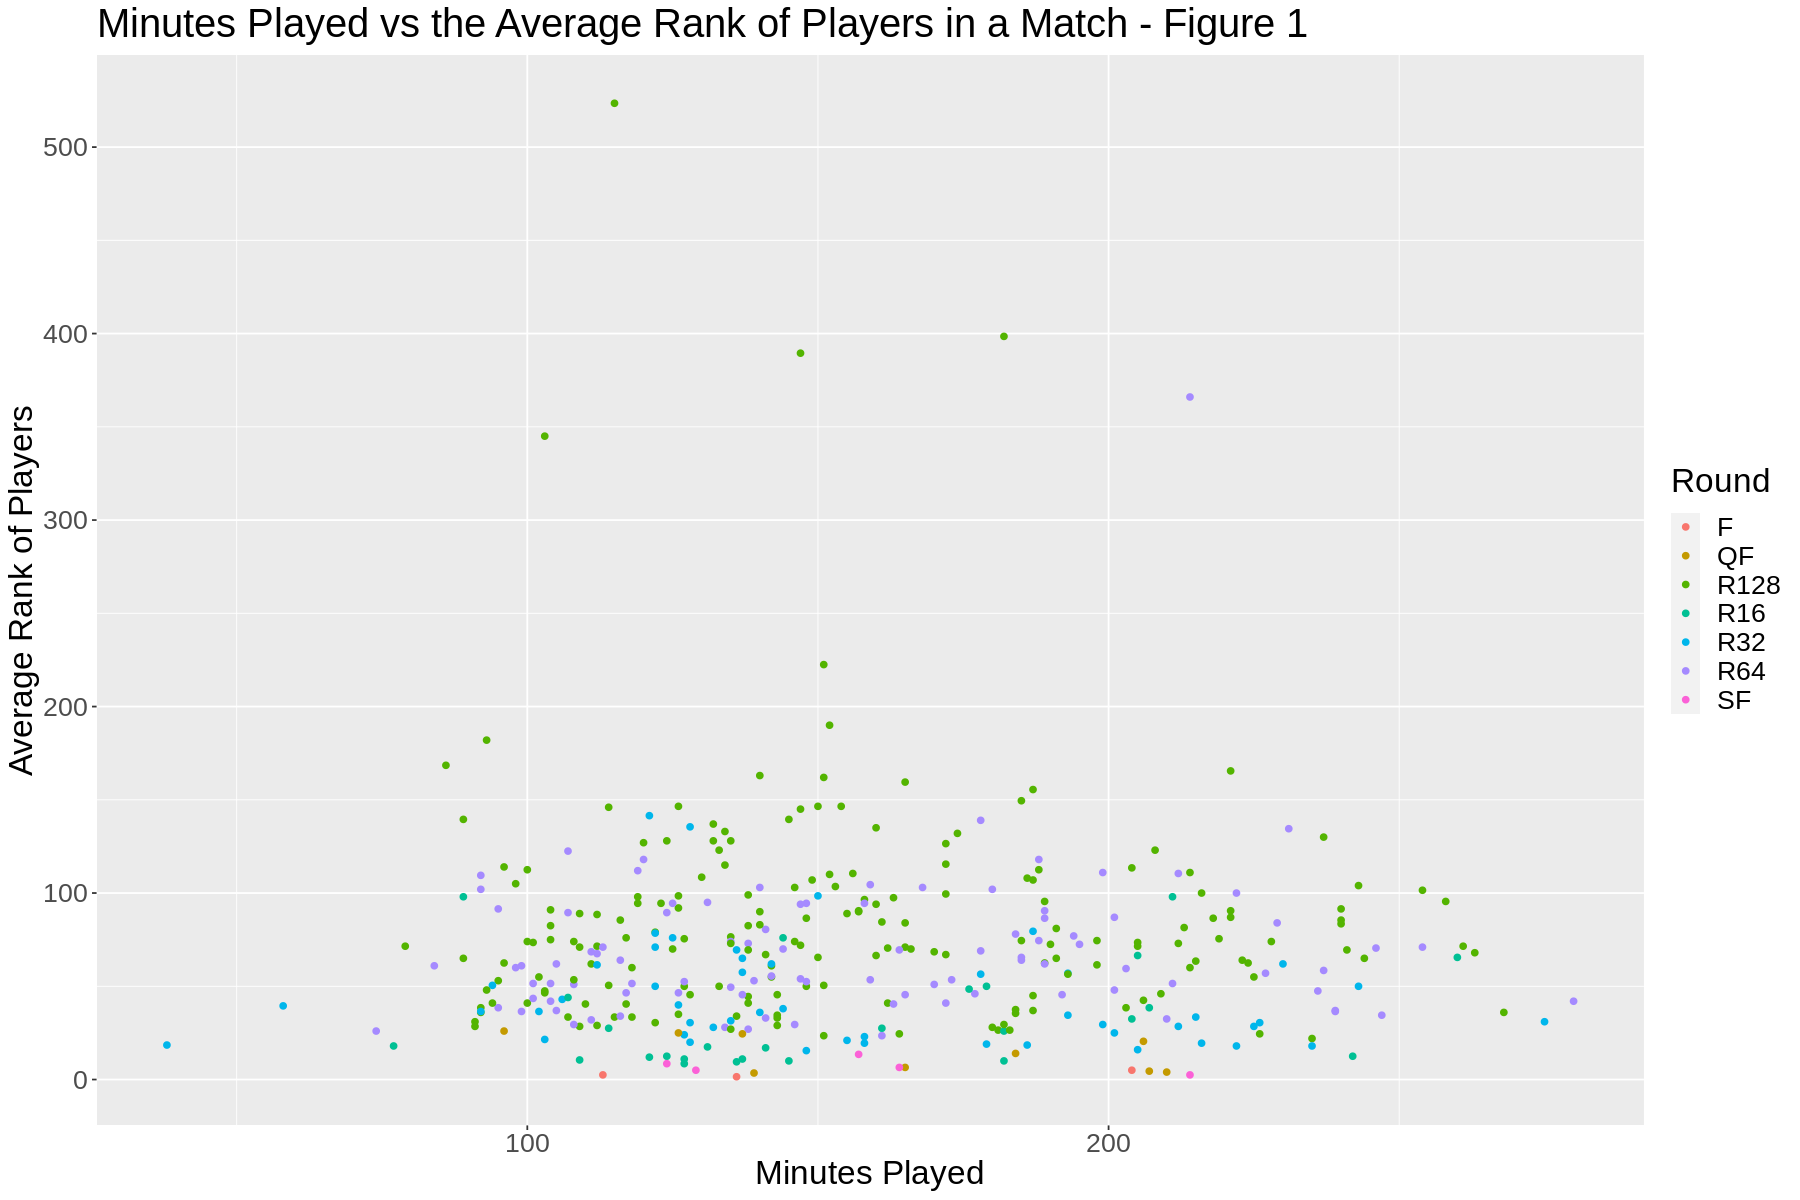

In [21]:
options(repr.plot.width = 15, repr.plot.height = 10) 

tennis_plot <- ggplot(tennis_comb, aes(x = minutes, y = avg_rank)) + 
                geom_point(aes(color = round)) +
                xlab("Minutes Played") +
                ylab("Average Rank of Players") +
                labs(color = "Round") +
                theme(text = element_text(size = 20)) + 
                ggtitle("Minutes Played vs the Average Rank of Players in a Match - Figure 1")
                
tennis_plot

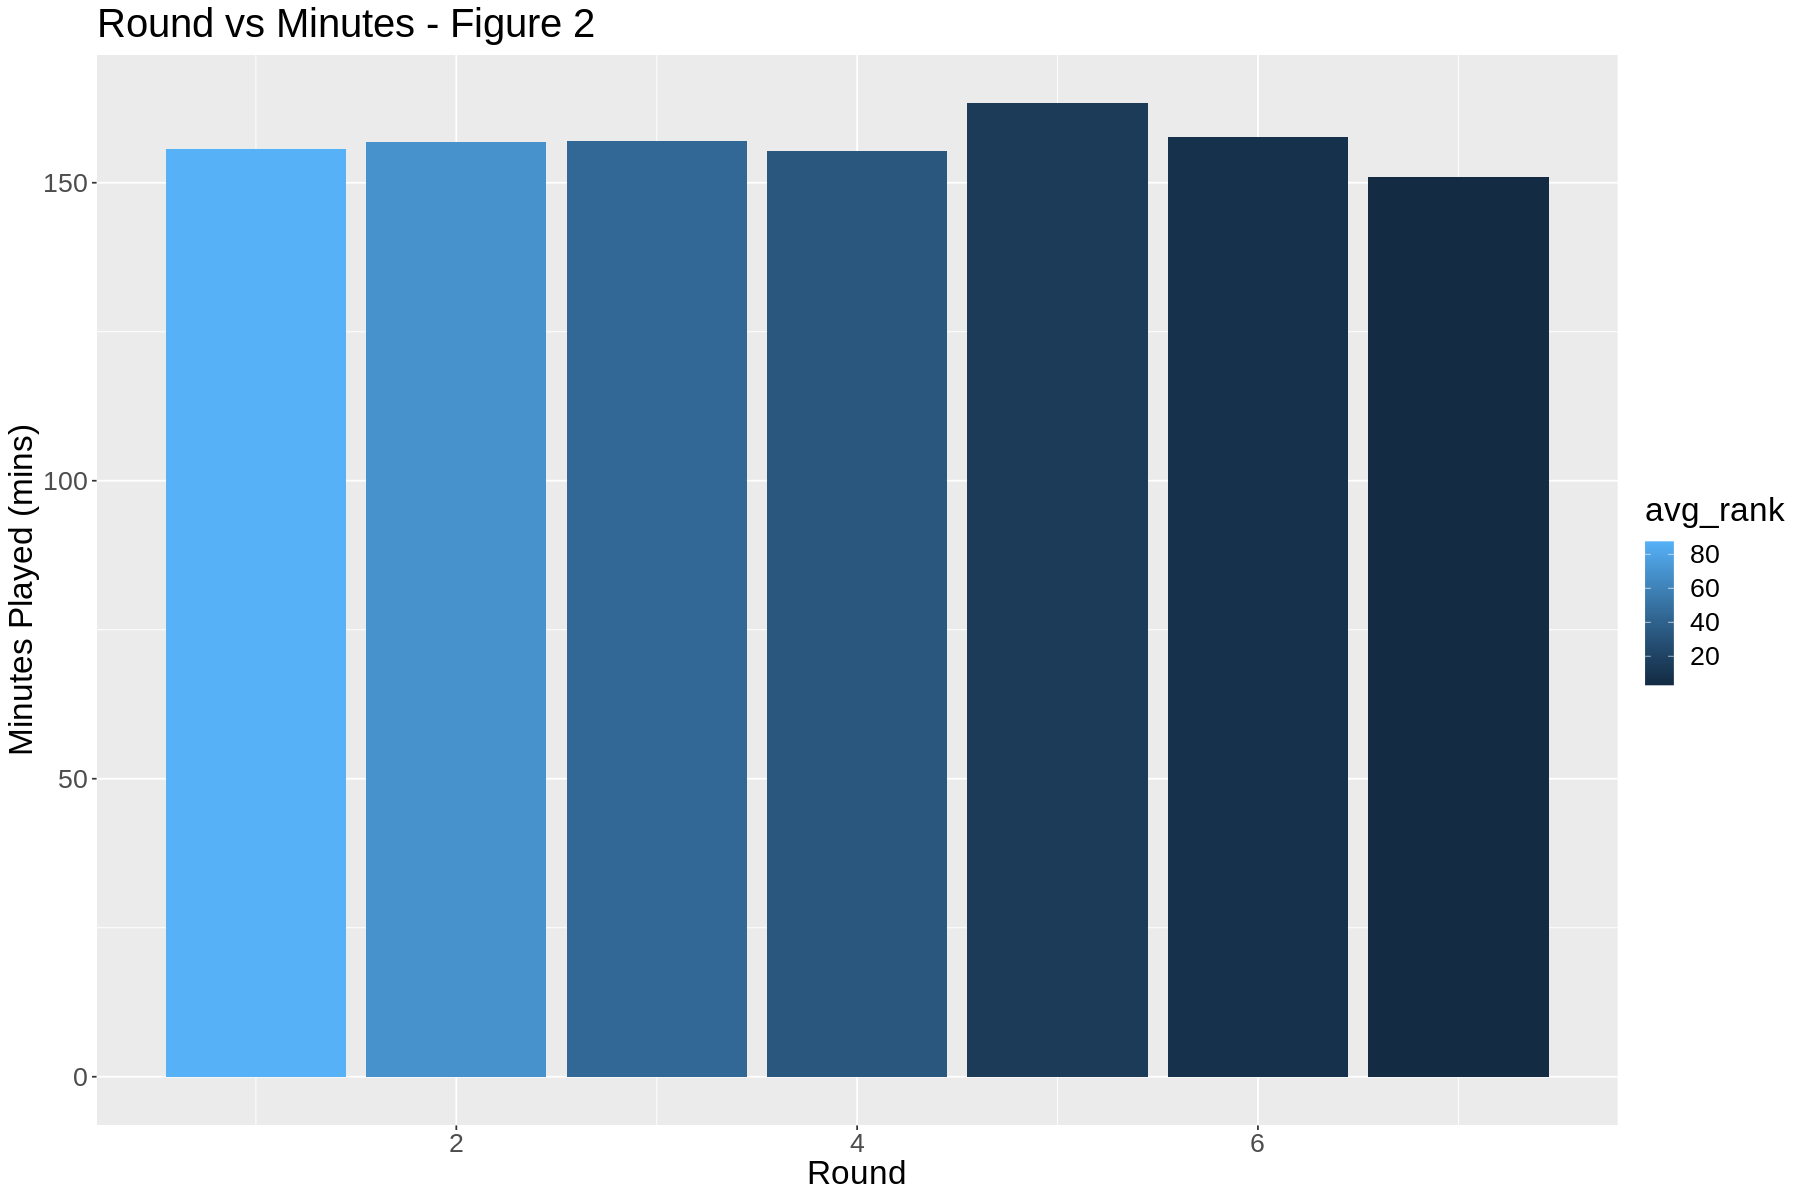

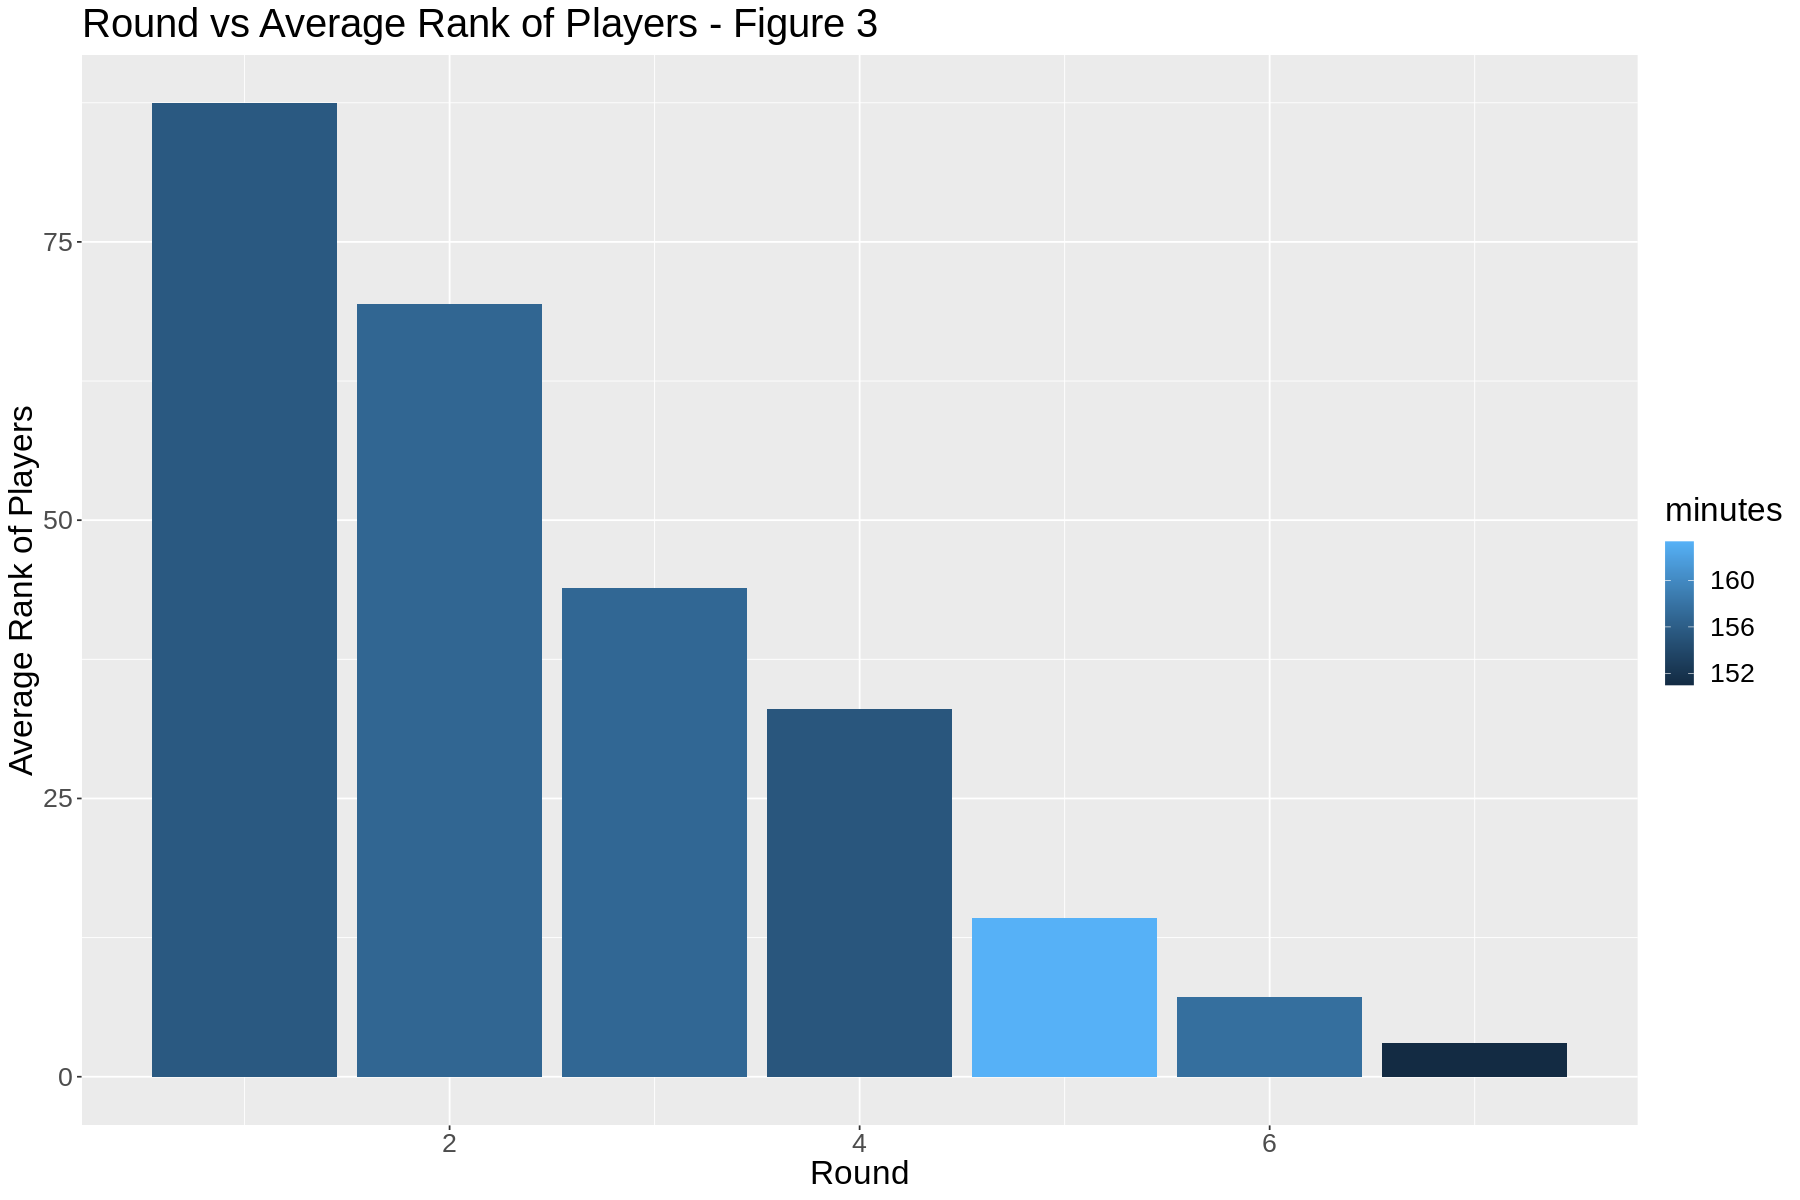

In [22]:
options(repr.plot.width = 15, repr.plot.height = 10) 

round_vs_minutes_bar <- ggplot(tennis_group, aes(x = round_n, y = minutes, fill = avg_rank)) + 
    geom_bar(stat = "identity") +
    xlab("Round") +
    ylab("Minutes Played (mins)") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Round vs Minutes - Figure 2")
round_vs_minutes_bar


round_vs_avg_rank_bar <- ggplot(tennis_group, aes(x = round_n, y = avg_rank, fill = minutes)) + 
    geom_bar(stat = "identity") +
    xlab("Round") +
    ylab("Average Rank of Players") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Round vs Average Rank of Players - Figure 3")
round_vs_avg_rank_bar

**Exploratory Visualization:** <p> As we grouped our dataset by round, we have summarized our dataset called tennis_group. Using tennis_group, we made two bar charts of visualizations by putting "round_n" on x-axis. This help us to see the how "minutes" and "average rank" related to different rounds, which gives us a rough idea of what we are looking for when doing the data analysis. We plan to analyze and predict what round of match does a new given point belong by using classification. When we saw these two graphs, we noticed that as that the bigger number the round is, the average ranks of players are smaller. This means that higher ranking players tend to play to further rounds since our data indicates that round 128 is round 1 here and round final is round 7 here. Also, I put color to fill out the third variable in each bar chart. In the first one graph we see that even though the minutes of different rounds are similar, we see darker color in bigger number of rounds. Also in the second graph, it seems like low ranking players play longer time comparing to high ranking players as the color goes darker as well. Therefore through these two visualizations we may assume that high ranking players play slightly less time and they are most likely going into further rounds.

**Data Analysis Step 1:** </p>
First we create our recipe and engine that we will be using. This process is set up for KNN-Classification and includes the **tune()** function so we can determine the appropriate K-Value to use. Additionally, we are scaling all our predictor variables as these amounts are not scaled and would provide a less optimal if we did not scale them.

In [7]:
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
      set_engine("kknn") %>%
      set_mode("classification") 

tennis_recipe <- recipe(round ~ ., data = tennis_comb) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

tennis_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

**Step 2:** </p>
We use cross-validation to help us tune our model by having the v-folds -1 amount of training sets fit our parameters while one set is used as validation to test the fit of our model. This process is repeated until all sets have been used as a validating test set.

In [8]:
tennis_vfold <- vfold_cv(tennis_comb, v = 3, strata = round)

tennis_workflow <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


**Step 3:** </p>
In this step we collect the metric from our v-fold function and are returned with the accuracy of our prediction engine with differing values of K. In this instance we see that k=14 was the optimal k-value

! Fold1: internal: No observations were detected in `truth` for level(s): 'F'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.3747192,3,0.01020786,Model01
2,roc_auc,hand_till,0.5528705,3,0.01899998,Model01
3,accuracy,multiclass,0.3906772,3,0.01800286,Model02
3,roc_auc,hand_till,0.5800723,3,0.02945416,Model02
5,accuracy,multiclass,0.4196325,3,0.01018373,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,roc_auc,hand_till,0.5942567,3,0.03523314,Model08
13,accuracy,multiclass,0.4410919,3,0.04398586,Model09
13,roc_auc,hand_till,0.6136357,3,0.04744460,Model09


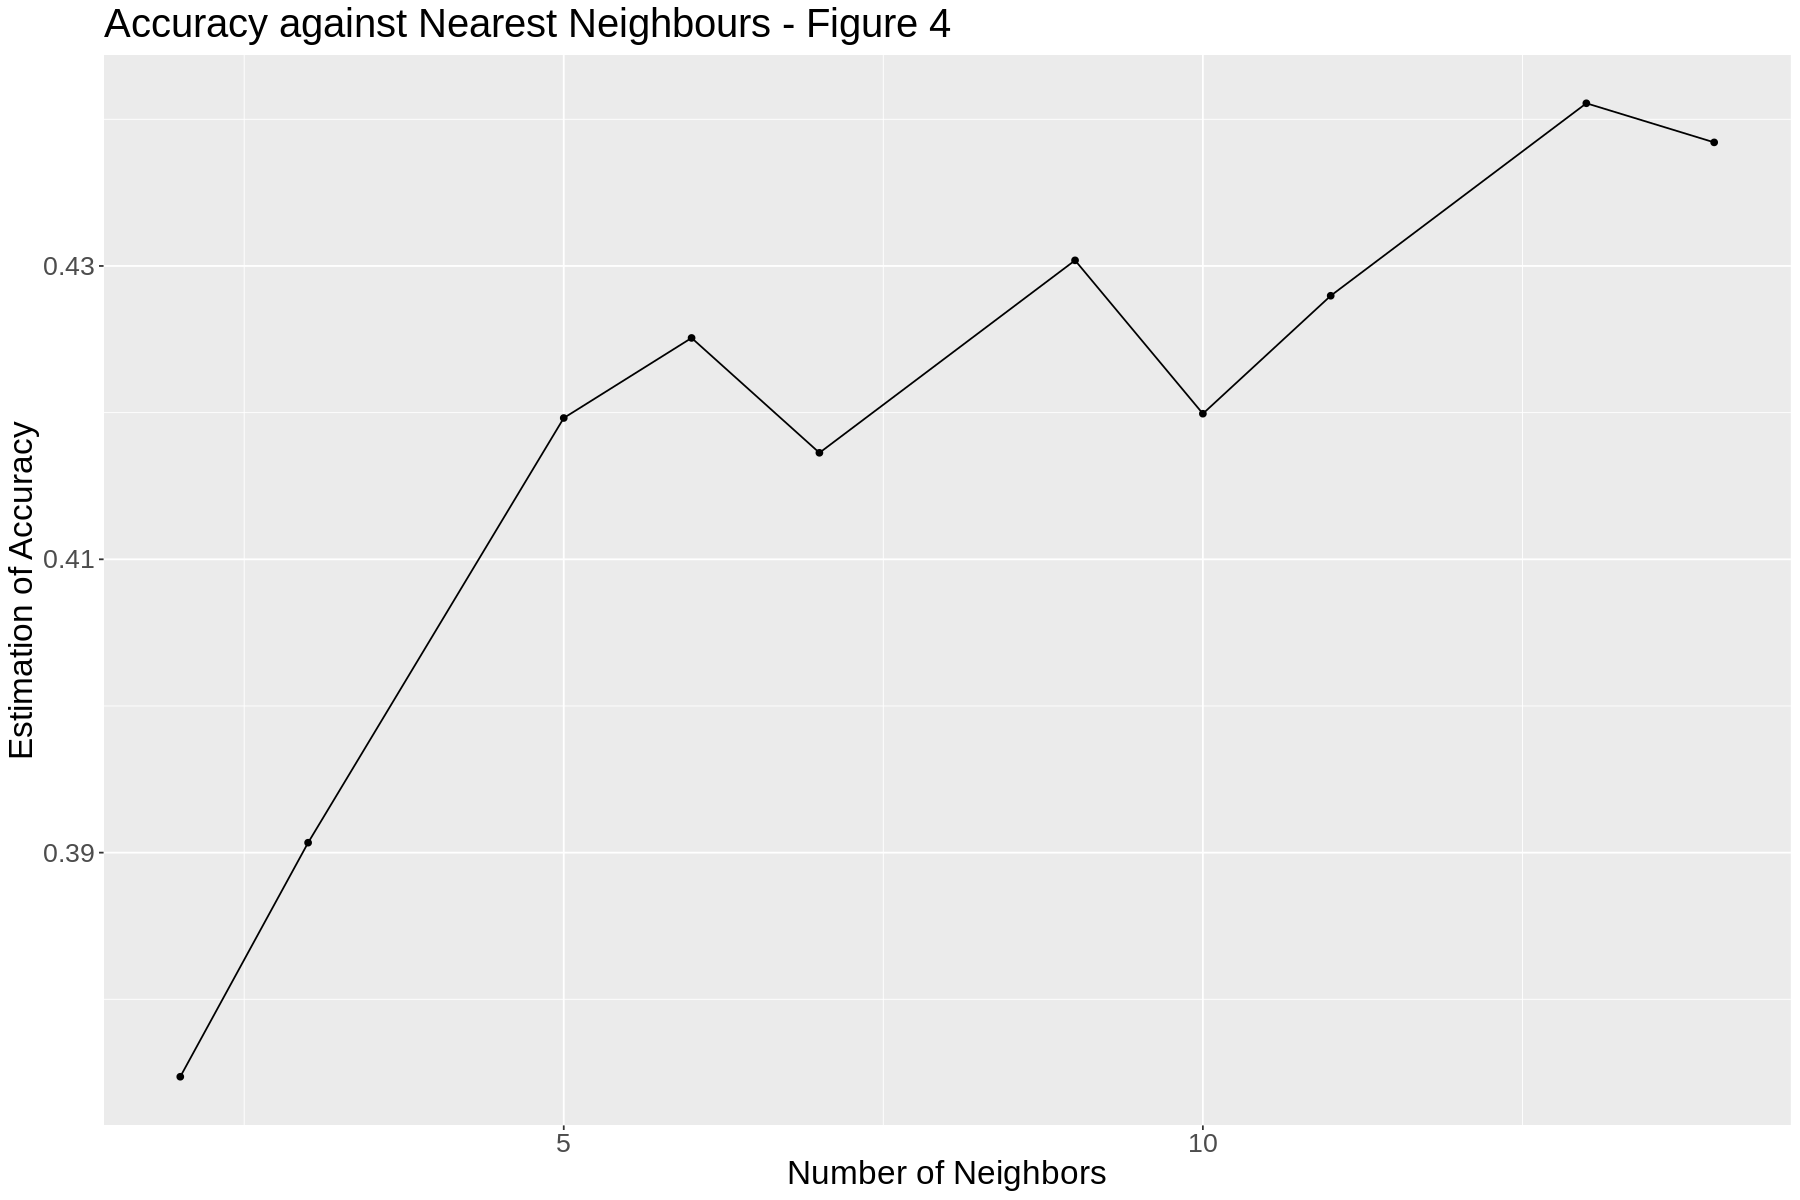

In [24]:
gridvals <- tibble(neighbors = seq(from = 1, to = 100))

tennis_results <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec) %>%
tune_grid(resamples = tennis_vfold, grid = 10) %>%
collect_metrics()
tennis_results

accuracy <- tennis_results %>%
filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Number of Neighbors", y = "Estimation of Accuracy") +
ggtitle("Accuracy against Nearest Neighbours - Figure 4") +
theme(text = element_text(size = 20)) 
cross_val_plot

In [26]:
tennis_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) %>%
set_engine("kknn") %>%
set_mode("classification")

tennis_fit <- workflow() %>%
add_recipe(tennis_recipe) %>%
add_model(tennis_spec2) %>%
fit(data = tennis_comb)
tennis_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~14, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.530343
Best kernel: rectangular
Best k: 14

In [29]:
tennis_metrics<-collect_metrics(resample_fit)
tennis_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.4384252,3,0.04135350
roc_auc,hand_till,0.6117448,3,0.04599418


In [30]:
knn_tune<-nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn")%>%
set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [31]:
knn_results <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = tennis_vfold, grid = 10) %>%
collect_metrics()
knn_results

! Fold1: internal: No observations were detected in `truth` for level(s): 'F'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.3747192,3,0.01020786,Model1
2,roc_auc,hand_till,0.5528705,3,0.01899998,Model1
3,accuracy,multiclass,0.3906772,3,0.01800286,Model2
3,roc_auc,hand_till,0.5800723,3,0.02945416,Model2
5,accuracy,multiclass,0.4196325,3,0.01018373,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,roc_auc,hand_till,0.5942567,3,0.03523314,Model7
13,accuracy,multiclass,0.4410919,3,0.04398586,Model8
13,roc_auc,hand_till,0.6136357,3,0.04744460,Model8


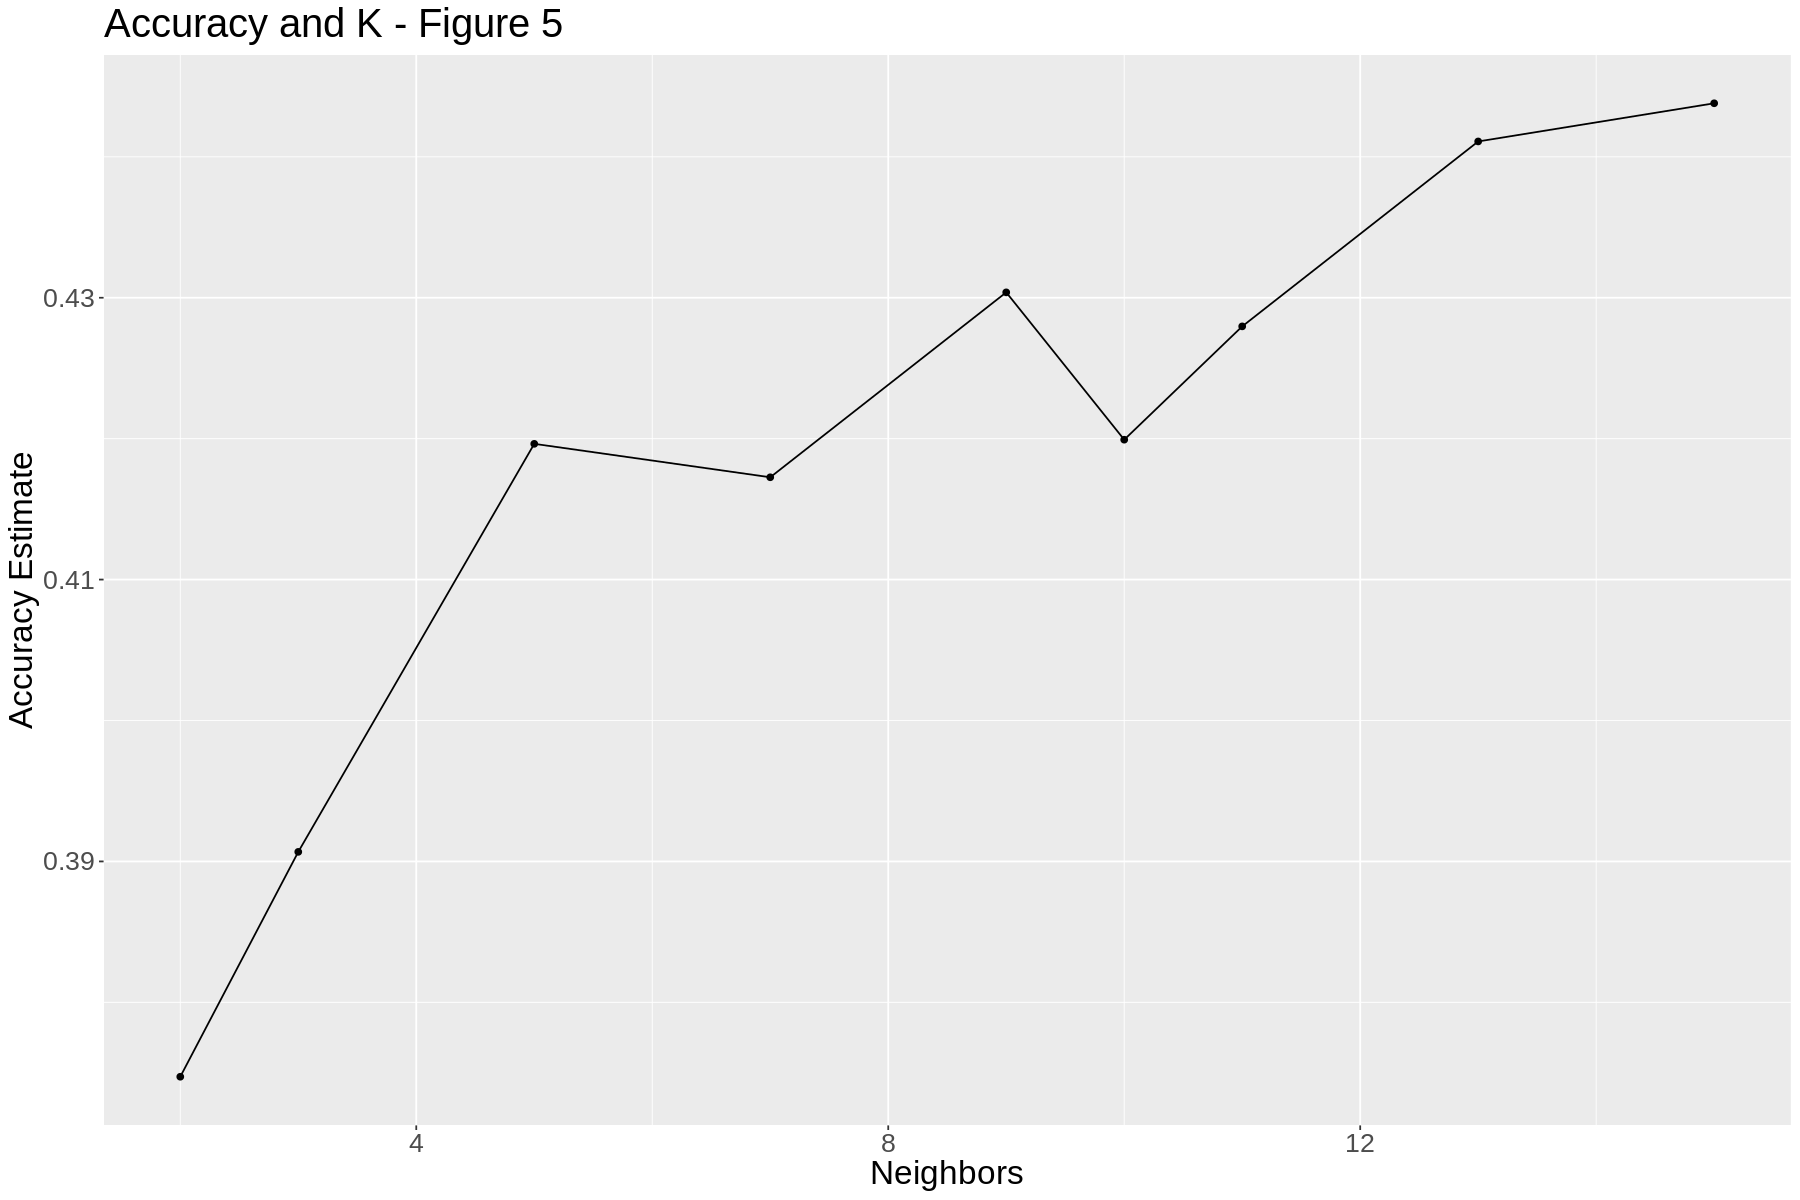

In [33]:
accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

 accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Accuracy and K - Figure 5") +
theme(text = element_text(size = 20)) 
 accuracy_versus_k

In [38]:
new_obs <- tibble(round = "R128", minutes = 120, total_ace = 11, avg_rank = 60, total_bpSaved = 10)
tennis_prediction <- predict(tennis_fit, new_obs)
tennis_prediction

new_obs2 <- tibble(round = "F", minutes = 136, total_ace = 23, avg_rank = 2, total_bpSaved = 5)
tennis_prediction2 <- predict(tennis_fit, new_obs2)
tennis_prediction2

.pred_class
<fct>
R128


.pred_class
<fct>
R32


**Discussion and Analysis:** <p> *Summary of Findings* </p> <p>By using knn - classification, we found that 14 neighbours was the best predictive value for our model, though we haven’t reached 50% of estimation of accuracy (we have the value around 0.496). This may have occurred due to the large difference between type of rounds. For example, there are many round 128 but for the finals there are only three observations. We attributed abnormality in our results to the nature of our predictive methods. Normally, these kinds of models are created to predict the results of a match but in our case, we are using data from a completed match to determine at what point in the tournament it was played. We see that the .pred.class and the true round is matched with approximately 50% accuracy. This could have occurred because of the values we chose to perform the prediction. The cross_val_plot indicates that as our k-value increases, the standard error decreases. We choose beside a point that we want to predict. Therefore our data analysis works with what we want to predict based on what we chose. However we may want to predict something else next time because we find that the result of prediction is not quite strong.</p>

*Expections of our findings* </p> These results are slightly unexpected as a higher correlation between the round and the variables was predicted, which would have made the classification model more accurate. There was a high correlation between round and average rank, which drove the predictions, while the other variables were much less linked to the round. This was likely because there were increasingly fewer matches the later in the tournament the rounds were, meaning there were less match statistics for those, making the amount of data available to predict those classes fewer. As a result, the whole model is less accurate since the training data is less ‘informative’ (contains less data that categorizes those rounds). To make this model more accurate in the future we would look to obtain a data set with a balanced amount of matches played across all rounds. </p>

*Impact of our findings* </p>
From our project one of the key findings would be the accuracy value from our predictive K-value chosen. As this value borders on 50%, the predictive capabilities of this model are perhaps not the greatest in determining the answer to our question. However, what this accuracy value does conveniently represent is the effect of human error. Similar to a match played in any sporting event, there is never a 100% guarantee on which competitor will be the victor. That is in part the reason why our model has difficulty evaluating in which round a tennis match may have occurred. Not always will top players advance to the finals just because they are ranked as the number one or number two seed. The results from this draws parallels to predictive models developed in other sporting scenarios and those who use these models, commonly being gamblers. In a study conducted on two groups of bettors, one group focussed on casino related betting and the other group being centralized around sporting events, results found that those who utilized a predictive model in the sporting scenario had a much higher level of behavioural apprehension. The sporting bettors were much more likely to be less trusting in the data put forward by the model. 

*Future questions this project poses* </p>
We connect our project to another research which uses Cross-Sectional Analysis to work on Classifications in Elite Caucasian Youth Tennis Players (Myburgh, 2019). Through providing background knowledge and methods of how the data is collected, it indicates the connection between each factor and the result of the match to explain how to choose the factors for prediction. From this research, we can conclude several questions that can be further explored: “Are the outcomes of the matches of different years similar?” “Can the results of prediction be applied to future matches?”

**References:** </p>
Myburgh, Gillian K., Sean P. Cumming, and Robert M. Malina. "Cross-Sectional Analysis Investigating the Concordance of Maturity Status Classifications in Elite Caucasian Youth Tennis Players." Sports Medicine - Open, vol. 5, no. 1, 2019. </p>
Ukhov, Ivan, et al. “Online Problem Gambling: A Comparison of Casino Players and Sports Bettors via Predictive Modeling Using Behavioral Tracking Data.” Journal of Gambling Studies, vol. 37, no. 3, Sept. 2021, pp. 877–97. Springer Link, https://doi.org/10.1007/s10899-020-09964-z.
